# DL Assignment 1 - Multi-class Classification with Neural Networks

This is the first **graded assignment** of the DL course. In the last homework assignment, you implemented a two layer neural network and trained it for predicting whether or not a flower was displayed in an image.

In this assignment, you will adopt the code in order to classify the type of flower displayed in an image. Hence, you will implement **multi-class classification**. In addition, you will add **momentum** to the optimization process, as well as **$\mathcal{l_2}$-regularization**.
You will also add more **hidden layers** to the network to see if it can increase the classification accuracy. At last, you will exchange the sigmoid activations of the hidden layers by **ReLU activations** to enable training of deeper networks. 

***

**After completing this assignment, you will have**
- learned to use **one-hot encodings** and **softmax activation** for performing **multi-class classification**.
- computed **forward** and **back propagation** for architectures with more than one hidden layer.
- implemented optimization using **momentum** and **$\mathcal{l_2}$-regularization**.
- used the **Sigmoid** and **ReLU activation functions** and their derivatives.


***

**Instructions**

- You'll be using Python 3 in the iPython based Google Colaboratory
- Lines encapsulated in "<font color='green'>`### START YOUR CODE HERE ###`</font>" and "<font color='green'>`### END YOUR CODE HERE ###`</font>", or marked by "<font color='green'>`# TODO`</font>", denote the code fragments to be completed by you.
- There's no need to write any other code.
- After writing your code, you can run the cell by either pressing `SHIFT`+`ENTER` or by clicking on the play symbol on the left side of the cell.
- We may specify "<font color='green'>`(≈ X LOC)`</font>" in the "<font color='green'>`# TODO`</font>" comments to tell you about how many lines of code you need to write. This is just a rough estimate, so don't feel bad if your code is longer or shorter.

Let's get started!

***

<font color='darkblue'>
  
**Remember**  
- Run your cells using SHIFT+ENTER (or "Run cell")
- Write code in the designated areas using Python 3 only
- Do not modify the code outside of the designated areas
</font>

<font color='red'>
  
**Note**  
You have to develop and submit your own solution. If we have reasons to believe you shared or did not submit your own work, we have to consider an attempted fraud. In this case your submission will be graded zero points and we reserve additional measures.
</font>

# 0 - Packages
At first, let's import the package you will need here:

- [numpy](www.numpy.org) remember our first lab: NumPy is the fundamental package for scientific computing with Python.

In [2]:
import numpy as np

BTW: Line numbers can be enabled by pressing `CTRL`+`M`+`L`.

# 1 - Obtaining the Image Dataset

Execute the code below for downloading the dataset as multiclass_flowers_64.npz:

In [3]:
#@title Download dataset and `utils`
archive = 'GA1.zip'
!wget -nv -t 0 --show-progress -O $archive 'https://cloud.tu-ilmenau.de/s/2HMX68JARY5yY9G/download'
!unzip -j $archive

import utils

GA1.zip                 [      <=>           ]   9.94M  9.55MB/s    in 1.0s    
2022-10-30 12:40:29 URL:https://cloud.tu-ilmenau.de/s/2HMX68JARY5yY9G/download [10420831] -> "GA1.zip" [1]
Archive:  GA1.zip
 extracting: multiclass_flowers_64.npz  
 extracting: utils.py                


The dataset is provided as archive of numpy arrays, each stored as binary file. We'll unpack them to `X_train, Y_train, X_validation, Y_validation`:

In [4]:
#@title Load and Preprocess Dataset
X_train, Y_train, X_validation, Y_validation = utils.load_npz_dataset('multiclass_flowers_64.npz')
X_validation = utils.flatten(X_validation)

classes = np.unique(Y_train)
num_classes = len(classes)
print('{} training and {} test samples loaded.'.format(Y_train.size, Y_validation.size))
print('Number of classes: ', num_classes)

_layertypes = list()

450 training and 50 test samples loaded.
Number of classes:  5


There are 5 different classes of flowers. Let's plot some of the images to get an idea about the task:

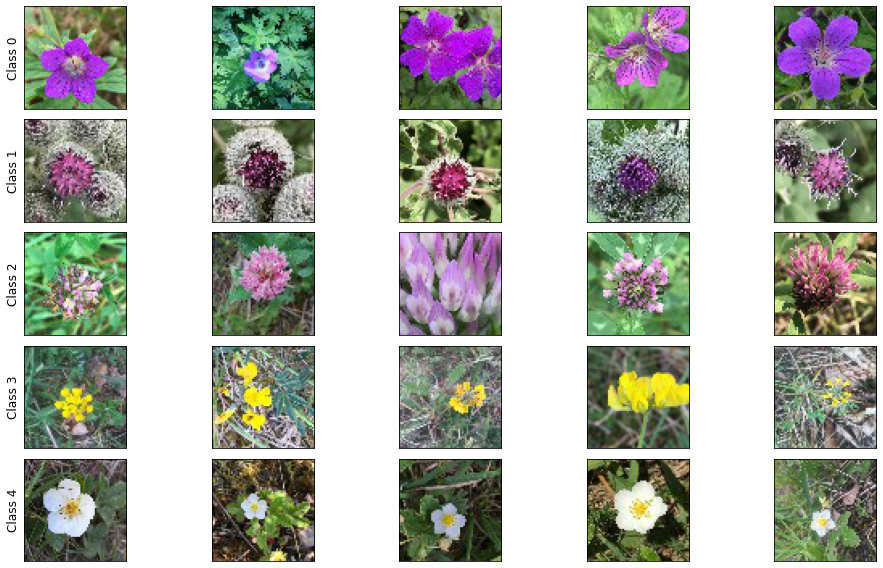

In [5]:
utils.plot_samples(X_train, Y_train, num_classes)

# 2 - The Multi-Class Setting
We used the binary classification setting so far. For binary classification on a single sample, our network predicts a scalar value $\hat{y}\in [0,1]$ that can be interpreted as probability of recognizing the positive class.

In the multi-class setting, our network will predict a vector of probabilities, i.e., one probability per class. Every sample will be assigned to exactly one class. Hence, all class probabilities per sample have to sum up to $1$.

In order to setup this multi-class setting, we have to adjust the labels $y$, the activation function for the networks output, as well as the loss function.

## 2.1 - One-hot Encoding of Labels
The input images were already flattened to fit our networks input requirements. However, the target values, i.e., the class labels, are just nominal values. Let's check the class labels of the first 10 training samples:

In [8]:
print(Y_train[:10])

[3 0 2 2 3 3 3 3 1 4]


As `Y_train[0]` is `3`, the first image displays a class `3` flower, the second image (`Y_train[1]`) a class `0` flower and so on. We could predict these target values using a single neuron as output of our network with an activation function different to the sigmoid function. However, this effects an explicit ordering of the classes (e.g., class `3` > class `1`). First of all, such order would be wrong in any case. Secondly, it confuses the network.

Instead, we apply a technique termed **one-hot encoding** to our target values. **One-hot encoding is used to represent categorical values as binary vectors.** *One binary row* will be created *for each class label*. The rows will be all zero values except for the index of the true class label. The resulting shape of the one-hot encoded label array will be `(n_classes, n_samples)`.

E.g., the label of the first training image is a `3`. This means that the 4th number (i.e., the number having index `3`) in the corresponding one-hot encoded label vector will be `1`. The rest of the vector will be `0`.

**Task**: complete the function `onehot()`, which will be used for encoding categorical target values into one-hot representations.

In [48]:
# GRADED FUNCTION: onehot (1 point)

def onehot(y, num_classes):
  """Encode categorical values into one-hot representation

  Args:
    y (numpy.ndarray): array of class indices; shape = (num_samples,)
    num_classes (int): number of classes

  Returns:
    numpy.ndarray: array of one-hot encoded class labels; shape = (num_classes, num_samples)
  """
  
  y = np.array(y)

  ### START YOUR CODE HERE ### (≈3 LOC)
  y_onehot=np.zeros((num_classes,len(y)))
  for idx, i in np.ndenumerate(y):
    # print(idx,i)
    y_onehot[i,idx]=1
  ### END YOUR CODE HERE ###
  
  return y_onehot

In [52]:
#@title test `onehot`
utils.test.onehot(onehot)

Testing output shape --> PASSED!
Testing output values --> PASSED!


## 2.2 - Class Label Prediction from Vector Outputs
In the binary classification setup discussed in Lab 1.2, the output layer was constituted of a single neuron. The scalar output $\hat{y}$ of that neuron represented the probability of the input $\vec{x}$ belonging to the positive class. We will use the same idea for multi-class predictions, i.e., using *one output neuron for each class*. Hence, the output layer will yield a vector of class probabilities.

**Task**: Complete the function `predict_multiclass` to return the class index predicted with maximum probability for each sample in `Y_hat`.

In [ ]:
# GRADED FUNCTION: predict_multiclass (1 point)

def predict_multiclass(Y_hat):
  """Per sample, return index of class predicted with max probability.
    
  Args:
    Y_hat (numpy.ndarray): Predicted class probabilities; shape = (num_classes, num_samples)
      
  Returns:
    numpy.ndarray : Array of indices of predicted classes; shape = (num_samples,)
  """

  ### START YOUR CODE HERE ### (≈1 LOC)
  
  ### END YOUR CODE HERE ###

  return y_prediction

In [ ]:
#@title test `predict_multiclass`
utils.test.predict_multiclass(predict_multiclass)

## 2.3 - Softmax activation

We will use the *softmax* function to convert the output of the last layer into probabilities that sum to one. The softmax function outputs a vector that represents the categorical probability distributions across the list of target classes. 

The softmax function is defined as

$S = \frac{e^{Z_j}}{\sum_j^K e^{Z_j}}$,

where $Z$ is the array of outputs of the last layer and $K$ is the number of classes.

**Task**: Implement the softmax function. Your code should work for vectors as well as for matrices of shape `(n_output, n_samples)`.

In [ ]:
# GRADED FUNCTION: softmax (1 point)

def softmax(input):
  """Compute the softmax score for each column of input array.
  
  Args:
    input (np.ndarray): array of shape = (num_classes, num_samples)

  Returns:
    np.ndarray: Column-wise softmax scores of input array
  """
  
  ### START YOUR CODE HERE ###  (≈3 LOC)
  
  ### END YOUR CODE HERE ###

  return S

In [ ]:
#@title test `softmax`
utils.test.softmax(softmax)

## 2.4 - Cross-entropy Loss

For measuring the error of our model, we need to compare the predicted class probability vectors in $\hat{Y}$ to the one-hot encoded class label vectors in $Y$. For binary classification, we used the binary cross-entropy loss. Here, we will use the **cross-entropy loss** in it's generalized form:

$l = - \sum_{j=1}^{K} y_j \log (\hat{y}_j)$,

where $j \in [1, \ldots, K]$ iterates over the $K$ classes. 

Remember that we take the **average loss** across all $m_\mathrm{batch}$ samples in a minibatch:

$\mathcal{L} = - \frac{1}{m_\mathrm{batch}}\sum_{i=1}^{m_\mathrm{batch}} \sum_{j=1}^{K} y_{j,i} \log (\hat{y}_{j,i})$.

**Task**: Compute the cross-entropy loss `loss` to complete the function `cross_entropy_loss()`.

In [ ]:
# GRADED FUNCTION: cross_entropy_loss (1 point)

def cross_entropy_loss(Y, Y_hat):
  """ Compute multi-class cross-entropy loss and its gradient w.r.t. `Y_hat`

  Args:
    Y (numpy.ndarray): One-hot encoded expected class labels; shape = (num_classes, num_samples)
        
    Y_hat (numpy.ndarray): Predicted labels; shape = (num_classes, num_samples)

  Returns:
    loss (numpy.float64): Value of the cross-entropy loss    
    dY_hat (numpy.ndarray): Gradient of cross-entropy loss w.r.t. Y_hat; shape = (num_classes, num_samples)
  """
  # prevent log(0)
  Y_hat += 1e-9
  
  # cross entropy loss
  ### START YOUR CODE HERE ###  (≈1 LOC)
  loss = 
  ### END YOUR CODE HERE ###

  # cross entropy derivative
  dY_hat = - Y / Y_hat

  return np.squeeze(loss), dY_hat

In [ ]:
#@title test `loss` in `cross_entropy_loss`
utils.test.cross_entropy_loss(cross_entropy_loss)

# 3 - Implement Layers

Your network will contain dense layers and different activation layers. We objectify these layers for making the forward and backward computations easier. In detail, each layer class will have a `forward` and `backward` method that are callable on arbitrary inputs of defined shape.

## 3.1 - Dense (fully-connected) Layer 

You already implemented the Dense layer in the DL Lab 1.2 notebook. This `Dense` class is provided in `utils`.

Lecture 1.3 discusses advanced optimization techniques using **momentum** from previous (or future) parameter updates and adaptive learning rates. In addition, **regularization techniques** are usually employed to prevent overfitting.

Here, your task is to extend the `Dense` layer by implementing
- $\mathcal{l}_2$-regularization, also termed "weight decay".
- momentum from previous updates

To implement weight decay, add the $\mathcal{l}_2$-term to the gradient w.r.t. the layerweights `W`, i.e. `self.dW`. The **weight decay factor** is stored in `self.weight_decay`. Check the lecture 1.3 slide 25 for the formula.

To implement the **momentum**, you have to compute the **updates $u^{(t+1)}$** (`weights_update` and `bias_update` in the code). The updates from previous iteration are stored in `self.weights_update_prev` for the weights and `self.bias_update_prev` for the bias. The momentum factor is stored as `self.gamma`. Check the lecture 1.3 slide 16 for the formulas.


Don't forget to apply the computed updates to the weights `self.W` and biases `self.b`!


**Task**: Complete the `update` method of the `Dense` class by implementing momentum and weight decay.

In [ ]:
# GRADED FUNCTION: Dense.update (3 points)

global WEIGHT_DECAY # weight decay factor

class Dense(utils.Dense):
  """ Dense layer using momentum during update. Inherited from `utils.Dense`.
  
  Attributes:
  ---
    num_neurons (int): number of neurons (equals the output size)
    input_shape (tuple): shape of the input data
    W (numpy.ndarray): layer weights
    b (numpy.ndarray): layer bias
    input (numpy.ndarray): layer input
    output (numpy.ndarray): layer output
    dW (numpy.ndarray): derivative w.r.t. weights `W`
    db (numpy.ndarray): derivative w.r.t. bias `b`
    gradient_out (numpy.ndarray): derivative w.r.t. layer input `input`
    gamma (float): momentum factor
    weight_decay (float): weight decay factor

  Methods:
  ---
    forward( input )
    backward( gradient_in )
    update( learning_rate )
  """

  def __init__(self, *args, gamma=.9, **kwargs):
    super().__init__(*args, **kwargs)
    self.gamma = gamma
    global WEIGHT_DECAY
    self.weight_decay = WEIGHT_DECAY
    
    # initialize previous updates for momentum
    self.weights_update_prev = np.zeros_like(self.W)
    self.bias_update_prev = np.zeros_like(self.b)


  def update(self, learning_rate):
    """ Update layer parameters `W`, `b` using `learning_rate` while applying 
    weight decay and momentum.

    Args:
      learning_rate (float): value of the learning rate
    """
    
    ### START YOUR CODE HERE ### (≈5 LOC)

    # weight decay: add l2-term to gradient `dW`

    # compute updates with momentum
    weights_update = 
    bias_update = 
    
    # apply updates to weights `W` and bias `b`

    ### END YOUR CODE HERE ###
    
    # store update for next iteration
    self.weights_update_prev = weights_update
    self.bias_update_prev = bias_update

## 3.2 - Activation layers

The `Sigmoid` class implements the sigmoid function as a layer. You already know it from the DL Lab 1.2 notebook:

In [ ]:
class Sigmoid:
  """ Activation layer using the logistic function (aka sigmoid function)
  
  Attributes:
  ---
    output (numpy.ndarray): layer output
    gradient_out (numpy.ndarray): derivative w.r.t. layer input `Z`
  
  Methods:
  ---
    forward( input )
    backward( gradient_in )
  """

  def __init__(self, input_shape):
    """Init an activation layer using the Sigmoid activation function.

    Initialize an activation layer for element-wise calculation of the sigmoid
    of a given input of shape `input_shape`.

    Args:
      input_shape (tuple): shape of input data `(num_features, num_samples)`
    """

    # allocate output
    self.output = np.zeros( input_shape )

  def forward(self, input):
    """Forward pass of `input` through sigmoid layer. 
    
    Compute the value of the sigmoid function for each element of `input`.
    The output is stored in `output`.

    Args:
      input (numpy.ndarray): layer input

    Returns:
      numpy.ndarray: layer output
    """
    self.output = 1 / (1 + np.exp(-input))
    return self.output

  def backward(self, gradient_in):
    """Backward pass of `gradient_in` through sigmoid layer. 
    The output is stored in `gradient_out`.

    Args:
      gradient_in (numpy.ndarray): gradient w.r.t. layer output
    
    Returns:
      numpy.ndarray: gradient w.r.t. layer input
    """
    self.gradient_out = gradient_in * self.output * (1 - self.output)
    return self.gradient_out

  def update(self, learning_rate):
    """Dummy method"""
    pass

The `Softmax` class uses your `softmax` function defined above:

In [ ]:
class Softmax:
  """ Softmax activation layer
  
  Attributes:
  ---
    output (numpy.ndarray): layer output
    gradient_out (numpy.ndarray): derivative w.r.t. layer input `Z`
  
  Methods:
  ---
    forward( input )
    backward( gradient_in )
  """

  _name = 'Softmax'

  def __init__(self, input_shape):
    """Init an activation layer using the Softmax function.

    Initialize an activation layer for calculation of the softmax
    of a given input of shape `input_shape`.

    Args:
      input_shape (tuple): shape of input data `(num_features, num_samples)`
    """
    # allocate output
    self.output = np.zeros( input_shape )

  def forward(self, input):
    """Forward pass of `input`: compute softmax activation. Output is stored in `output`.
    
    Args:
      input (numpy.ndarray): layer input

    Returns:
      numpy.ndarray: softmax activated layer output
    """
    # Subtract maximum in `Z_in` for better numerical stability
    input -= np.max(input)
    # Compute softmax (using your `softmax` definition from above)
    self.output = softmax(input)
    return self.output

  def backward(self, gradient_in):
    """Backward pass of `gradient_in` through softmax layer. 
    Output is stored in `gradient_out`. 
    
    Args:
      gradient_in (numpy.ndarray): gradient w.r.t. layer output

    Returns:
      numpy.ndarray: gradient w.r.t. layer input
    """
    t1 = np.einsum('ji,ki->ijk', self.output, self.output)
    t2 = np.einsum('ji,kj->ijk', self.output, np.eye(self.output.shape[0], self.output.shape[0]))
    dS = t2-t1
    self.gradient_out = np.einsum('ijk,ki->ji', dS, gradient_in)

    return self.gradient_out

  def update(self, learning_rate):
    """Dummy method"""
    pass

# 4 - Learning Rate Schedules

We typically decrease the learning rate $\eta$ with progressing training. The function or rule defining the $\eta(t)$ is commonly termed **learning rate schedule**. In addition to the learning rate schedules discussed in Lecture 1.3, a very useful rule is to decrease the learning rate when the training progress shows no improvement after a defined number of epochs (the so called *patience*). This should allow the optimizer to find a minimum in the loss landscape more efficiently. Such type of schedule is often referred to as **reduce learning rate on plateau**.  The training progress is assessed by a metric monitored during training, typically the `validation_loss`. 

# 5 - Implementing a 2 Layer Neural Network

Using the layers, loss function, and learning rate schedules defined above, we can now implement our neural network.

**Task**: Complete the `forward`, `backward`, and `update` methods of the `NeuralNet` class.

In [ ]:
# GRADED FUNCTION: NeuralNet.forward (1 point)
# GRADED FUNCTION: NeuralNet.backward (1 point)
# GRADED FUNCTION: NeuralNet.update (1 point)

class NeuralNet(utils.NeuralNet):
  """Your feed-forward neural network.
  
  Attributes:
  ---
    input_shape (tuple): shape of input data
    num_classes (int): number of classes
    num_neurons (int): number of neurons in hidden layer(s) (default=5)
    loss_function (func): loss function to quantify the network's prediction error
    batch_size (int): batch size (default=100)
    number_of_parameters (int): number of trainable model parameters
    init_lr (float): initial learning rate (default=1e-3)
    lr_scheduler (func): learning rate scheduler (default=lr_step_decay)
    shuffle (bool): shuffle data during training (default=True)
    verbose (bool): print stats after each epoch (default=True)
  
  Methods:
  ---
    prepare_layers()
    forward()
    backprop()
    update()
    fit()
    predict()
  """

  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)


  def set_architecture(self):
    """Define architecture by stacking layers into list `self.layers`"""
  
    # hidden layer with `num_neurons` neurons
    self.layers.append(
        Dense(self.num_neurons, (self.input_shape[0], self.batch_size))
    )
    # sigmoid activation of hidden layer output
    self.layers.append( 
        Sigmoid(self.layers[-1].output.shape)
    )

    # output layer with `num_classes` neurons
    self.layers.append( 
        Dense(self.num_classes, self.layers[-1].output.shape)
    )
    # softmax activation of output layer
    self.layers.append( 
        Softmax(self.layers[-1].output.shape)
    )


  def forward(self, X):
    """Forward propagate input `X` through network and return network output.

    Args:
        X (numpy.ndarray): input data of shape `(num_features, num_samples)`

    Returns:
        numpy.ndarray: output of last layer ("Y_hat")
    """

    ### START YOUR CODE HERE ### (≈3 LOC)

    ### END YOUR CODE HERE ###

    return A


  def backward(self, gradient):
    """Backpropagate gradient `dY_hat` w.r.t. predicted output through the network. 

    Args:
        dY_hat (numpy.ndarray): gradient w.r.t. predicted output
    """

    ### START YOUR CODE HERE ### (≈2 LOC)
    # HINT: you can reverse lists using extended slice syntax `[::-1]` or the build-in `reversed` method

    ### END YOUR CODE HERE ###

  def update(self, learning_rate):
    """Call `update` method of each trainable layer.
    
    Args:
      learning_rate (float): learning rate used for updating layer weights
    """
    
    ### START YOUR CODE HERE ### (≈2 LOC)
    # HINT: make sure you are using the `learning_rate` provided as function argument
    
    ### END YOUR CODE HERE ###

## 5.1 - Testing the Forward Computation

Now it's time to initialize the network and test the forward propagation.

Let's define the hyperparameters and create an instance of your `NeuralNet`:

In [ ]:
# Hyperparameters
BATCHSIZE = 50
LEARNING_RATE = 3e-2
WEIGHT_DECAY = 5e-2
NUM_EPOCHS = 100
NUM_CLASSES = len(np.unique(Y_train))
NUM_NEURONS = 20

In [ ]:
my_NN = NeuralNet(
    utils.flatten(X_train).shape,
    NUM_CLASSES,
    predict_function=predict_multiclass,
    loss_function=cross_entropy_loss,
    onehot_function=onehot,
    num_neurons=NUM_NEURONS,
    batch_size=BATCHSIZE,
    init_lr=LEARNING_RATE,
    lr_scheduler=utils.reduce_lr_on_plateau_schedule,
)

The layers were initialized with normal distributed random weights. Hence, the untrained network will return random predictions.
The validation split is balanced, i.e., it contains the same amount of for all classes. For multi-class classification on balanced data, random guessing should return an accuracy of roughly 20%:

In [ ]:
Y_validation_hat = my_NN.predict( X_validation )
print('Accuracy: {:.1f}%'.format(100*np.mean( Y_validation_hat == Y_validation )))

## 5.2 - Training and Evaluation

Now it's time to finally train your network. 

Train it for 100 epochs with a minibatch size of 50 using the `.fit()` method. If your implementation is correct, you should achieve a classification accuracy >70% on the validation data:

In [ ]:
my_NN_history = my_NN.fit(
    X_train, Y_train,
    X_validation, Y_validation, 
    NUM_EPOCHS,
)

We can again call the `.predict()` method on the validation data again and see how the network improved:

In [ ]:
Y_validation_hat = my_NN.predict( X_validation )
print('Accuracy: {:.1f}%'.format(100*np.mean( Y_validation_hat == Y_validation )))

In addition, we stored the loss as well the training and validation accuracy of the network after each epoch in the `history` dictionary. Let's plot the learning curve, i.e., the loss over epochs, and the accuracies:

In [ ]:
utils.plot_history(my_NN_history)

#6 - Weight Decay and Stochastic Gradient Descent

## 6.1 - Impact of Weight Decay on Weight Values

You implemented $\mathcal{l}_2$-regularization (aka weight decay) in Section 3.1 of this notebook. However, it would be interesting to understand the reason for the regularizing effect of weight decay.

Let's plot the distribution of weight values of a network trained using weight decay:

In [ ]:
utils.plot_weights_distribution(my_NN)

How does this compare to the distribution of weights of a network trained without weight decay? Let's run an experiment:

In [ ]:
WEIGHT_DECAY = 0

# initialize a new network with same settings as `my_NN` but no weight decay
my_NN_no_weight_decay = NeuralNet(
    utils.flatten(X_train).shape,
    NUM_CLASSES,
    predict_function=predict_multiclass,
    loss_function=cross_entropy_loss,
    onehot_function=onehot,
    num_neurons=NUM_NEURONS,
    batch_size=BATCHSIZE,
    init_lr=LEARNING_RATE,
    lr_scheduler=utils.reduce_lr_on_plateau_schedule,
)

# train the network
my_NN_no_weight_decay_history = my_NN_no_weight_decay.fit(
    X_train, Y_train,
    X_validation, Y_validation, 
    NUM_EPOCHS,
)

# plot history and weights distribution
utils.plot_history(my_NN_no_weight_decay_history)
utils.plot_weights_distribution(my_NN_no_weight_decay)

WEIGHT_DECAY = 5e-2 # set to original value

**Question**: What do you observe from comparing of the loss history and weight values' distributions of the networks trained with weight decay factor `5e-2` and `0`? (1 sentence)

Briefly explain the impact of weight decay on the network weights. (1 sentence)

### **GRADED RESPONSE**: (2 points)
- Observation: 
- Explanation: 

## 6.2 - Stochastic Gradient Descent vs. Full-Batch Gradient Descent

During optimization, the evolution of two elements of a weight matrix of your network was tracked. This can be used to visualize the training process by

In [ ]:
utils.plot_weights_loss(my_NN_history)

What would this look like if we use the entire training data in each optimization step, i.e., if we apply full-batch gradient descent instead of using mini-batches?

**Task**: Initialize a new network `my_NN_full_batch` with **same hyperparameters** but **batch size set equal to the number of training samples**. Train the network and investigate the difference in the history and weights vs. loss plots.

In [ ]:
# GRADED: my_NN_full_batch (1 point)

### START YOUR CODE HERE ### (≈1 LOC)
my_NN_full_batch = NeuralNet(
    utils.flatten(X_train).shape,
    NUM_CLASSES,
    predict_function=predict_multiclass,
    loss_function=cross_entropy_loss,
    onehot_function=onehot,
    num_neurons=NUM_NEURONS,
    batch_size=, # TODO
    init_lr=LEARNING_RATE,
    lr_scheduler=utils.reduce_lr_on_plateau_schedule,
)

### END YOUR CODE HERE ###
my_NN_full_batch_history = my_NN_full_batch.fit(
    X_train, Y_train,
    X_validation, Y_validation, 
    NUM_EPOCHS,
)

In [ ]:
utils.plot_history(my_NN_full_batch_history)
utils.plot_weights_loss(my_NN_full_batch_history)

# 7 - Increasing the Networks Depth

You may achieve an accuracy approaching ≈80% using the 2 layer neural network. Let's see if you can increase the accuracy by adding **two more hidden layers**.

In order to add more hidden layers, you need to adjust the

- `set_architecture()`

and, depending on your solutions for the  `NeuralNet` class,  also the 

- `forward()`
- `backprop()`
- `update()`

methods of the `DeepNeuralNet` class below.

**Task**: Implement the neural network `DeepNeuralNet` with three hidden layers of width `self.num_neurons` and sigmoid activation. If required, update the `forward()`, `backward()`, and `update()` methods accordingly.

In [ ]:
# GRADED FUNCTION: DeepNeuralNet.set_architecture (1 point)
# GRADED FUNCTION: DeepNeuralNet.forward (1 point)
# GRADED FUNCTION: DeepNeuralNet.backward (1 point)
# GRADED FUNCTION: DeepNeuralNet.update (1 point)

class DeepNeuralNet(NeuralNet):
  """Feed-forward neural network with three hidden layers. Inherits from `NeuralNet`."""

  def __init__(self,*args, **kwargs):
    super().__init__(*args, **kwargs)

  def set_architecture(self):
    """Define the architecture: three hidden layers with `num_neurons` neurons 
    and sigmoid activation. The output layer has `num_classes` neurons with 
    softmax activation.
    """
    ### START YOUR CODE HERE ### (≈7 LOC)

    ### END YOUR CODE HERE ###


  def forward(self, X):
    """Forward propagate input `X` through network and return network output.

    Args:
        X (numpy.ndarray): input data of shape `(num_features, num_samples)`

    Returns:
        numpy.ndarray: output of last layer ("Y_hat")
    """

    ### START YOUR CODE HERE ### (≈3 LOC)
    
    ### END YOUR CODE HERE ###

    return A


  def backward(self, gradient):
    """Backpropagate gradient `dY_hat` w.r.t. predicted output through the network. 

    Args:
        dY_hat (numpy.ndarray): gradient w.r.t. predicted output
    """

    ### START YOUR CODE HERE ### (≈2 LOC)
    # HINT: you can reverse lists using extended slice syntax `[::-1]`
    
    ### END YOUR CODE HERE ###


  def update(self, learning_rate):
    """Call `update` method of each trainable layer.
    
    Args:
      learning_rate (float): learning rate used for updating layer weights
    """

    ### START YOUR CODE HERE ### (≈2 LOC)
    # HINT: make sure you are using the `learning_rate` provided as function argument
    
    ### END YOUR CODE HERE ###

## 7.1 - Training and Evaluation

Initialize an instance of the `DeepNeuralNet` and train for 100 epochs:

In [ ]:
my_DNN = DeepNeuralNet(
    utils.flatten(X_train).shape,
    NUM_CLASSES,
    predict_function=predict_multiclass,
    loss_function=cross_entropy_loss,
    onehot_function=onehot,
    num_neurons=NUM_NEURONS,
    batch_size=BATCHSIZE,
    init_lr=LEARNING_RATE,
    lr_scheduler=utils.reduce_lr_on_plateau_schedule,
)

my_DNN_history = my_DNN.fit(
    X_train, Y_train,
    X_validation, Y_validation, 
    NUM_EPOCHS
)

utils.plot_history(my_DNN_history)

What happened? SGD is having a hard time finding an optimum for your deep network. Reason are the small gradients of the sigmoid function:

In [ ]:
utils.plot_sigmoid(Sigmoid)

A problem with the sigmoid (and $\tanh$) activation function is their flatness for small and large input values. In addition, the value for the sigmoid derivative is always notably smaller than $1$. In fact, the maximum of the derivative is $0.25$. If we backpropagate gradients through a series of sigmoid layers, the gradients become smaller and smaller by being multiplied to values $\leq 0.25 $, quickly resulting in **vanishing gradients**.

## 7.2 - ReLU and Swish Activation Functions

The **ReLU** (Rectified Linear Unit) activation, defined as 

$\mathrm{ReLU}(z) = max(0, z)$.

is far better suited for Deep Learning with many layers. First of all, it is more computationally efficient compared to the sigmoid function. In addition, the derivative of the ReLU function

$\frac{d}{dz} \mathrm{ReLU}(z) = \begin{cases} 
0 & \text{if  }  z \leq 0 \\
1 & \text{if  }  z > 0 \\
\end{cases}$

is either $0$ or $1$. Hence, you can stack much more layers without decreasing the gradient magnitudes.

In [ ]:
# GRADED FUNCTION: ReLU.forward (1 point)
# GRADED FUNCTION: ReLU.backward (1 point)

class ReLU:
  """ Rectified linear unit activation layer
  
  Attributes:
  ---
    output (numpy.ndarray): layer output
    gradient_out (numpy.ndarray): derivative w.r.t. layer input `Z`
  
  Methods:
  ---
    forward( input )
    backward( gradient_in )
  """

  def __init__(self, input_shape):
    # allocate output
    self.output = np.zeros( input_shape )

  def forward(self, input):
    """Forward pass of `input` through ReLU layer. 
    
    Compute the value of `max(0, input)` for each element of `input`.
    The output is stored in `output`.

    Args:
      input (numpy.ndarray): layer input

    Returns:
      numpy.ndarray: layer output
    """
    ### START YOUR CODE HERE ### (≈1 LOC)
    
    ### END YOUR CODE HERE ###

    return self.output

  def backward(self, gradient):
    """Backward pass of `gradient_in` through ReLU layer. 
    Output is stored in `gradient_out`. 
    
    Args:
      gradient_in (numpy.ndarray): gradient w.r.t. layer output

    Returns:
      numpy.ndarray: gradient w.r.t. layer input
    """

    ### START YOUR CODE HERE ### (≈1 LOC)
    
    ### END YOUR CODE HERE ###
    
    return self.gradient_out

  def update(self, learning_rate):
    """Dummy method"""
    pass

Also the ReLU function can have a disadvantage: if an activation is below $0$ the gradient will be $0$ too. Hence, neurons with $0$ ReLU activation won't get updated. On one hand this can be beneficial, as not all neurons get activated and the output will be sparse, which can save computations and be more efficient. On the other hand, if these activations are below $0$ for all inputs, the neurons generally won't update during Gradient Descent, causing the **dying ReLU** problem which ultimately decreases a networks's capacity.

This dying ReLU problem can be mitigated, e.g., by assigning a small positive slope for $z<0$ which is termed as **leaky ReLU**. However, another nice solution is the so called [**Swish** activation function](https://arxiv.org/abs/1710.05941):

$\mathrm{Swish}(z) = z \cdot \sigma(\beta z) = \frac{z}{1+ \exp^{-\beta z}}$,

with the either constant or trainable parameter $\beta$. Implement the Swish function below and see for yourself:

In [ ]:
class Swish:
  """Swish activation layer
  
  Attributes:
  ---
    output (numpy.ndarray): layer output
    gradient_out (numpy.ndarray): derivative w.r.t. layer input `Z`
  
  Methods:
  ---
    forward( input )
    backward( gradient_in )
  """

  def __init__(self, input_shape, beta=1.):
    # allocate output
    self.output = np.zeros( input_shape )
    self._beta = beta

  def forward(self, input):
    """Forward pass of `input` through Swish layer. 

    Args:
      input (numpy.ndarray): layer input

    Returns:
      numpy.ndarray: layer output
    """
    self.input = input
    self.output = input /( 1 + np.exp(- self._beta * input) )
    return self.output

  def backward(self, gradient):
    """Backward pass of `gradient_in` through ReLU layer. 
    Output is stored in `gradient_out`. 
    
    Args:
      gradient_in (numpy.ndarray): gradient w.r.t. layer output

    Returns:
      numpy.ndarray: gradient w.r.t. layer input
    """
    self.gradient_out = gradient * ( self._beta * self.output + 1/(1+np.exp(-self._beta * self.input)) * (1 - self._beta * self.output))
    return self.gradient_out

  def update(self, learning_rate):
    """Dummy method"""
    pass

In [ ]:
utils.plot_relu_swish(ReLU, Swish)

## 7.3 - DeepNeuralNet with ReLU Activation

**Task:** Below is a copy of your `DeepNeuralNet`. Replace the `Sigmoid` activations in `DeepNeuralNet_ReLU` with `ReLU` activations. In case your ReLU solution is not workable, use the `Swish` activation function.

In [ ]:
# GRADED FUNCTION: DeepNeuralNet_ReLU.set_architecture (1 point)

class DeepNeuralNet_ReLU(DeepNeuralNet):
  """Feed-forward neural network with 3 hidden layers and ReLU activation. 
  Inherits from `DeepNeuralNet`.
  """

  def __init__(self,*args, **kwargs):
    super().__init__(*args, **kwargs)

  def set_architecture(self):
    """Define the architecture: three hidden layers with `num_neurons` neurons 
    and ReLU activation. The output layer has `num_classes` neurons with 
    softmax activation.
    """

    ### START YOUR CODE HERE ### (≈7 LOC)

    ### END YOUR CODE HERE ###

Initialize an instance of the `DeepNeuralNet_ReLU` and train for 100 epochs:

In [ ]:
my_DNN = DeepNeuralNet_ReLU(
    utils.flatten(X_train).shape,
    NUM_CLASSES,
    predict_function=predict_multiclass,
    loss_function=cross_entropy_loss,
    onehot_function=onehot,
    num_neurons=NUM_NEURONS,
    batch_size=BATCHSIZE,
    init_lr=LEARNING_RATE,
    lr_scheduler=utils.reduce_lr_on_plateau_schedule,
)

my_DNN_history = my_DNN.fit(
    X_train, Y_train,
    X_validation, Y_validation, 
    NUM_EPOCHS
)

utils.plot_history(my_DNN_history)

***

# Congratulations on completing Assignment 1!

You've just coded your own neural networks in NumPy and trained them for classifying different classes of plant species in images. What you should have learned is

- how to use one-hot encodings for representing categorical data, e.g., class labels,
- how to use the softmax function and cross-entropy loss for multi-class classification,
- how to compute forward and backward propagations in networks with more than one hidden layer,
- how $\mathcal{l_2}$-regularization affects the distribution of weights,
- how batch sizes impact the optimization process,
- that sigmoid activations induce vanishing gradients, and
- that the ReLU activation function help mitigate vanishing gradients.

---
# Submission Instructions

You may now submit your notebook to moodle:
- Make sure **each code cell** has an **output**.
- Save the notebook (`CTRL`+ `s` or '*File*' -> '*Save*').
- Click on '*File*' -> '*Download .ipynb*' for downloading the notebook as **IPython Notebook file**.
- Upload the downloaded IPython Notebook file to **Moodle**.